In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from functions import *

In [2]:
# Window version
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# M1 MAC version
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(DEVICE)

mps


In [3]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = 'MLP'
dataset = "MNIST"
save_model_path = f'your path/result/{model_type}_{dataset}.pt'

In [4]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root='your path/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root='your path/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10))
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [6]:
exec(f'model = {model_type}()')
print(model)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


Epoch: 1, Train loss: 0.308
------------------------------
Epoch: 2, Train loss: 0.138
------------------------------
Epoch: 3, Train loss: 0.096
------------------------------
Epoch: 4, Train loss: 0.073
------------------------------
Epoch: 5, Train loss: 0.057
------------------------------


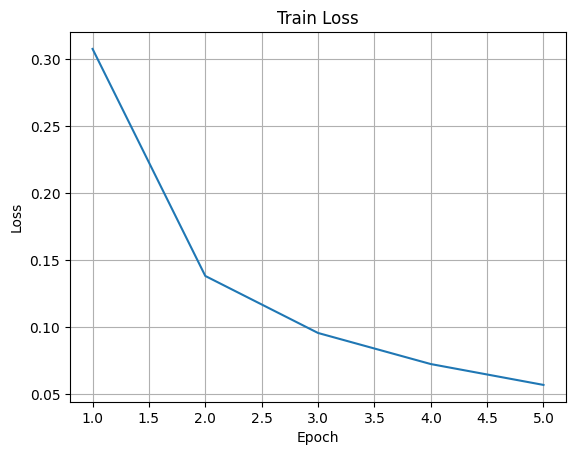

In [7]:
if new_model_train:
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.grid()

In [8]:
load_model = torch.load(save_model_path)

In [9]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 97.52/10000 (97.52) %
79510


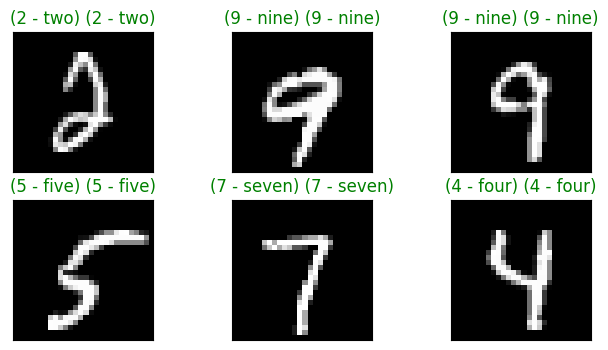

In [10]:
Test_plot(load_model, test_DL)